# Machine Learning hand-in 4

This handin is about implementing and using representative-based clustering
algorithms.

The handin is mandatory, and should be done groups of 2-3 students. Each group
must prepare a report in PDF format as outlined below. Please submit all your
Python files in a zip file, and your PDF report outside the zip file, to
Blackboard no later than **Monday, December 19 at 9:00 AM**.

All data and Python files are available below.

For questions and issues regarding this hand-in, please use the
[course discussion forum](https://bb.au.dk/webapps/blackboard/content/launchLink.jsp?course_id=_54703_1&toc_id=_830772_1).
If you have problems that for some reason cannot be shared
on the discussion forum, contact the teaching assistant, Mathias Rav, either
by coming to his office, Nygaard 334, or by sending an email to [rav@cs.au.dk](mailto:rav@cs.au.dk).

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# oh so pretty!
def float_formatter(x):
    if x < 0.001 and x > 0:
        return "   >0" 
    elif x == 0:
        return "    0" 
    else:
        return "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [5]:
def plot_matrix(x, y, group, fmt='.', **kwargs):
    """
    Given two d-dimensional datasets of n points,
    makes a figure containing d x d plots, where the (i, j) plot
    plots the ith dimension against the jth dimension.
    """

    x = np.asarray(x)
    y = np.asarray(y)
    group = np.squeeze(np.asarray(group))
    n, p = x.shape
    n_, q = y.shape
    n__, = group.shape
    assert n == n_ == n__
    groups = sorted(set(group))
    if isinstance(fmt, str):
        fmt = {k: fmt for k in groups}
    fig, axes = plt.subplots(p, q, squeeze=False, **kwargs)
    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            for g in groups:
                ax.plot(x[group == g, i], y[group == g, j], fmt[g])
            if len(axes) > 2:
                ax.locator_params(tight=True, nbins=4)

def plot_groups(x, group, fmt='.', **kwargs):
    """
    Helper function for plotting a 2-dimensional dataset with groups
    using plot_matrix.
    """
    n, d = x.shape
    assert d == 2
    x1 = x[:, 0].reshape(n, 1)
    x2 = x[:, 1].reshape(n, 1)
    plot_matrix(x1, x2, group, fmt, **kwargs)

## Data sets

In this hand-in, you will work with two different data sets: The Iris data set (for clustering) and two images (for compression).

### Iris data set

The Iris data set is included in sklearn as the `load_iris` function in the
`sklearn.datasets` module.

In [6]:
import sklearn.datasets
iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']

The Iris data set consists of 150 four-dimensional points.

In [ ]:
data.shape

The labels are integers between 0 and 2.

In [ ]:
set(labels)

One way of visualizing the four-dimensional point set is by projecting it down to two dimensions, for instance by picking the second and third dimension of the data set.

In [ ]:
data_2d = data[:, 1:3]
plot_groups(data_2d, labels, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))

We can also make all 16 different plots of this kind, that is, we can make 4 × 4 plots where the (*i*, *j*)th plot displays axis *i* of the data set against axis *j*.

In [ ]:
plot_matrix(data, data, labels, {0: 'o', 1: 's', 2: '^'}, figsize=(12, 12))

A third way of dealing with the data set in just two dimensions is by applying **principal component analysis** (PCA) as discussed in class.

Luckily, sklearn contains a class to compute exactly this.

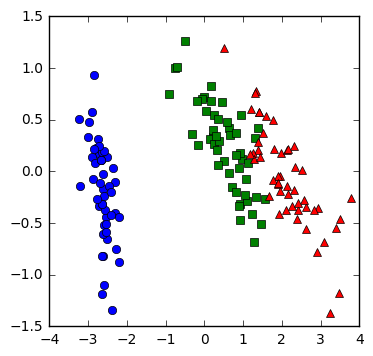

In [8]:
import sklearn.datasets
import sklearn.decomposition

# Load Iris data set
iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']
# Apply PCA
pca = sklearn.decomposition.PCA(2)
data_pca = pca.fit_transform(data)
# Plot
plot_groups(data_pca, labels, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))

### Image compression data

For the image compression part of this hand-in, you will use the following two images.

In [9]:
import scipy.misc

def download_image(url):
    filename = url[url.rindex('/')+1:]
    try:
        with open(filename, 'rb') as fp:
            return scipy.misc.imread(fp) / 255
    except FileNotFoundError:
        import urllib.request
        with open(filename, 'w+b') as fp, urllib.request.urlopen(url) as r:
            fp.write(r.read())
            return scipy.misc.imread(fp) / 255

img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
img_stairs = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_stairs.jpg')

In [ ]:
plt.imshow(img_facade)

In [ ]:
plt.imshow(img_stairs)

## Tasks

### Implementing EM and the K-means algorithm

You must implement the K-means algorithm and the Gaussian Mixture Expectation
Maximization algorithm as discussed on p. 349 and p. 335 of the textbook [ZM].
For the EM algorithm, you may use the `pdf` function below to compute the probability
densities in the Gaussian Mixture model.

You should use the Python code displayed previously to load and display Iris data
and apply PCA to reduce it from four dimensions to two.

Use the 2d Iris data to validate your algorithms (compare the results you get
with the results in the textbook on the same data), and run your algorithms on
the 4d data and compare.

#### Code structure

You are allowed to structure your code however you want, but you may want to use the following guidelines to get started.

You can structure your implementation of the K-means algorithm as follows.
First, you should implement a function `closest` that takes an `n × d` data matrix and a `k × d` matrix of centers and computes for each data point the closest center.

In [10]:
def closest(data, centers):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    
    # Insert your code here
    dist = np.zeros([n,k])
    for kk in range(k):
        center = centers[kk,:]
        for nn in range(n):
            dist[nn,kk] = np.sqrt(np.sum((data[nn,:]-center)**2))
    rep = np.argmin(dist, axis=1)
    
    # rep should contain a representative index for each data point
    assert rep.shape == (n,)
    assert np.all((0 <= rep) & (rep < k))
    return rep

You should implement a function that implements the K-means cost function, that is, a function that takes an `n × d` data matrix, a `k × d` matrix of centers, and a representative array mapping each data point to a center.

In [11]:
def kmeans_cost(data, centers, rep):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    assert rep.shape == (n,)

    # Insert your code here
    data_rep = centers[rep]
    cost = np.sum(np.sqrt(np.sum((data_rep-data)**2)))

    return cost

In [9]:
# test kmeans_cost: (Martin)
assert kmeans_cost(data,data,closest(data,data)) == 0.0

Finally, you should implement the K-means algorithm described in class. You should have a stopping parameter `epsilon` and stop when the centers move less than `epsilon` in an iteration.

In [12]:
def kmeans(data, k, epsilon):
    data = np.asarray(data)
    n, d = data.shape

    # Initialize centers
    # randomly chosen points from data is used as centers (same datapoint)
    centers = data[np.random.choice(range(n), size=k, replace=False),:]

    tired = False
    old_centers = np.zeros_like(centers)
    while not tired:
        old_centers[:] = centers

        rep = closest(data, centers)
        for kk in range(k):
            if any(rep==kk):
                centers[kk,:] = np.average(data[rep==kk,:], axis=0)
        dist = np.sqrt(((centers - old_centers) ** 2).sum(axis=1))
        tired = np.max(dist) <= epsilon

    return centers

(150, 2)
[[ 94 228]
 [683 607]
 [199  61]
 [425 146]
 [662 234]
 [118 580]
 [ 92 739]
 [350 355]
 [428 640]
 [145 410]]


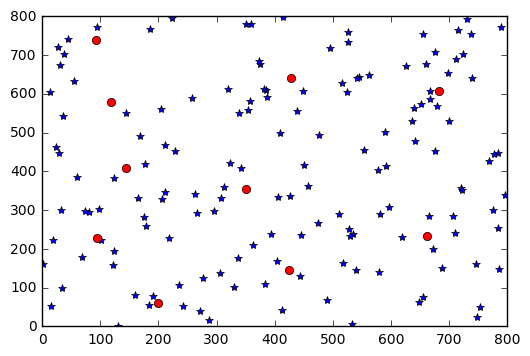

In [11]:
# test kmeans

data = np.random.choice(range(800), size=300, replace=False).T.reshape(-1,2)
print(data.shape)
plt.figure()
plt.plot(data[:,0],data[:,1], '*')

clusters = kmeans(data,10,0.0000001)
print(clusters)
plt.plot(clusters[:,0],clusters[:,1], 'ro')

For your implementation to the Gaussian Mixture exercise, you may want to use the following two helper functions.

The first function takes a description of a Gaussian Mixture (that is, the mean, covariance matrix and prior of each Gaussian) and returns the probability densities of each point.

In [13]:
from scipy.stats import multivariate_normal
def pdf(points, mean, cov, prior):
    points, mean, cov = np.asarray(points), np.asarray(mean), np.asarray(cov)
    prior = np.asarray(prior)
    n, d = points.shape
    k, d_1 = mean.shape
    k_2, d_2, d_3 = cov.shape
    k_3, = prior.shape
    assert d == d_1 == d_2 == d_3
    assert k == k_2 == k_3, "%s %s %s should be equal" % (k, k_2, k_3)

    # Compute probabilities
    prob = []
    for i in range(k):
        if prior[i] < 1 / k ** 3:
            prob.append(np.zeros(n))
        else:
            prob.append(
                prior[i] *
                multivariate_normal.pdf(
                    mean=mean[i], cov=cov[i], x=points, allow_singular=True))
    prob = np.transpose(prob)  # n x k
    # Normalize cluster probabilities of each point
    prob = prob / np.sum(prob, axis=1, keepdims=True)  # n x k

    assert prob.shape == (n, k)
    assert np.allclose(prob.sum(axis=1), 1)
    return prob

The following helper function computes the most likely class of each point under a given Gaussian Mixture.

In [14]:
def most_likely(points, mean, cov, prior):
    prob = pdf(points, mean, cov, prior)
    return np.argmax(prob, axis=1)

When implementing the Gaussian Mixture E-M algorithm, you may want to start out with the following code structure.

In [109]:
def scale(points, mean, cov):
    scale =  np.identity(points.shape[1]) * 1/cov.max()
    cov_scale = [scale]*cov.shape[0]
    points = (scale @ points.T).T
    mean = (scale @ mean.T).T
    cov = scale @ cov @ scale
    return points, mean, cov

def scaleMean(mean, scale, scale_min):
    return (scale @ (mean-scale_min).T).T

def em(points, k, epsilon, mean=None, pad=0.0, maxiter = None, log = False):
    log_data=None
    if log == True and maxiter is not None:
        log_data = np.zeros(maxiter+1)
    points = np.asarray(points)
    n, d = points.shape

    # Initialize and validate mean
    if mean is None:
        # Randomly pick k points
        mean = points[np.random.choice(range(n), size=k, replace=False)]

    # Validate input
    mean = np.asarray(mean)
    k_, d_ = mean.shape
    assert k == k_
    assert d == d_

    # Initialize cov, prior
    cov = np.asarray([np.identity(d)]*k)
    
    
    prior = np.ones(shape=(k))/k

    tired = False
    old_mean = np.zeros_like(mean)
    Em = np.log(0)
    q = 0
    
    while not tired:
        old_mean[:] = mean

        # Expectation step
        sPoints, sMean, sCov = scale(points, mean, cov)
        px_c = pdf(points, mean, cov, prior)
        px = (prior * px_c).sum(axis=1)
        pc_x = prior[np.newaxis, :] * ( px_c / px[:, np.newaxis])
        
        # Maximization step
        # calculate weights
        #We believe that any category must contain at least 10% of the points

        # We calculate prior, and do some padding. The idea is, that we believe that X% of the data must be
        # distributed evently across our classes. So we can always select some X% percent of our datapoints,
        # which will be evently distributed. This is pretty much the same as pseudocounting.
        prior = ((pc_x.sum(axis = 0)) / n)*(1-pad) + pad/k
        
        
        # calculate mean
        mean = np.nan_to_num(((pc_x.T @ points).T/pc_x.sum(axis=0)).T)
        pointsMinusMean = np.transpose((points[:, :, np.newaxis]-mean.T), (2, 0, 1))[:, :, :, np.newaxis]
        pointsMinusMean_T = np.transpose(pointsMinusMean, (0, 1, 3, 2))
        cov = np.nan_to_num((pc_x.T[:, :, np.newaxis, np.newaxis] 
               * (pointsMinusMean @ pointsMinusMean_T)).sum(axis=1)/pc_x.sum(axis=0)[:, np.newaxis, np.newaxis])
        
        # Finish condition
        Em_ = np.log(px).sum(axis=0)
        dist = np.absolute(Em-Em_)
        Em = Em_
        if (q % 10 == 0):
            print("\rdist is " + str(dist) + " after " + str(q) + " iterations", end="")
        tired = dist < epsilon
        if maxiter != None:
            if log == True:
                log_data[q] = dist
            tired = q >= maxiter
        q += 1

    # Validate output
    #print("\rFinal dist was: " + str(dist) + " after " + str(q) + "iterations.")
    assert mean.shape == (k, d)
    assert cov.shape == (k, d, d)
    assert prior.shape == (k,)
    return mean, cov, prior, log_data

In [16]:
def vote_labels(guessed, actual):
    respons = np.zeros_like(guessed)
    for l in np.unique(guessed):
        vl = np.argmax(np.bincount(actual[guessed == l]))
        respons[guessed == l] = vl
    return respons

C:\Users\Morten\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log


dist is 0.127274433216 after 10 iterations

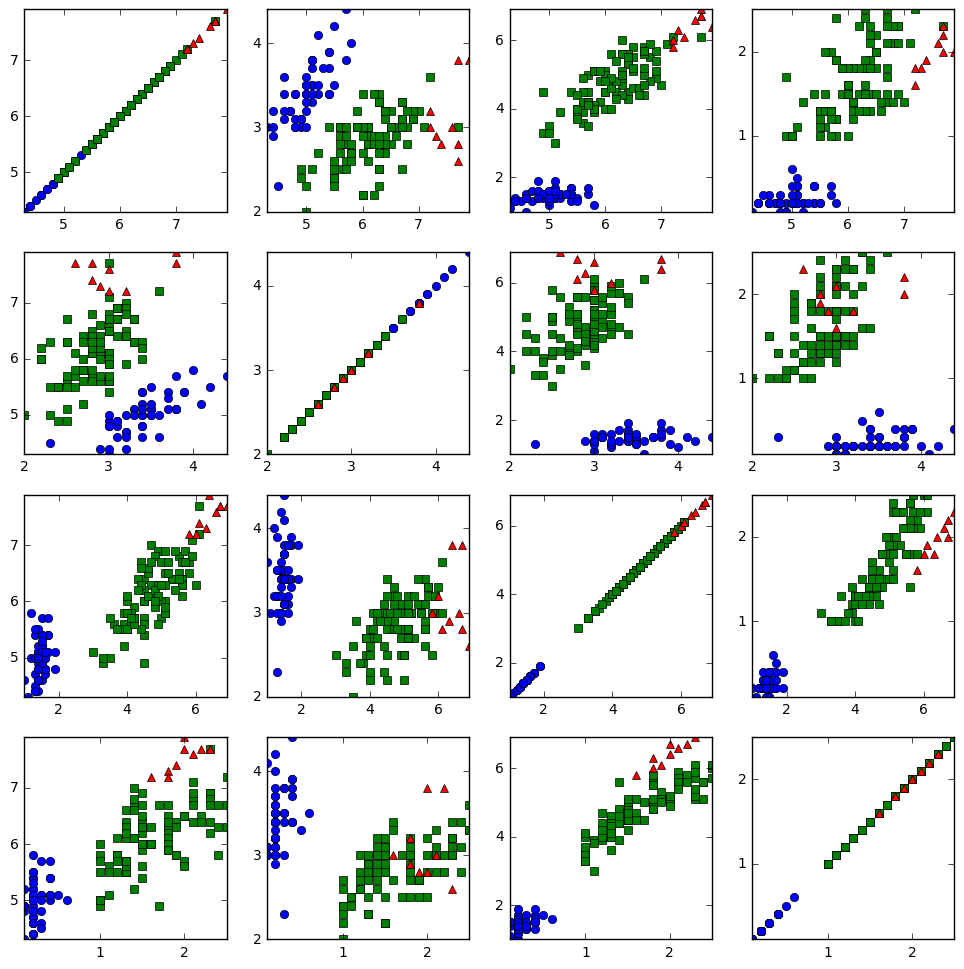

In [118]:
# test em

import sklearn.datasets
iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']

plt.figure()

mean, cov, prior, log_data = em(data, 3, 0.01, pad=0.1)#, maxiter=10000, log=True)
guessed_labels = most_likely(data, mean, cov, prior)
voted_labels = vote_labels(guessed_labels, labels)
plot_matrix(data, data, voted_labels, {0: 'o', 1: 's', 2: '^'}, figsize=(12, 12))

### Cost function for the K-means problem

To ensure that your implementation of the K-means algorithm is correct, you
should implement the cost function (objective function / optimization goal)
for the K-means problem. Print the cost after each iteration of the K-means
algorithm -- the cost should be decreasing.

### Evaluating clusterings

Implement the F1 score (build the contingency table p. 426, measure pp. 427-428)
and the silhouette coefficient (pp. 444-445), and compare the quality of
several runs of your algorithms with different values for *k*.

In [22]:
def f1(predicted, labels):
    n, = predicted.shape
    assert labels.shape == (n,)
    r = np.max(predicted) + 1
    k = np.max(labels) + 1

    # Implement the F1 score here
    contingency = np.zeros((r, k))
    for i in range(r):
        for j in range(k):
            contingency[i,j] = np.sum(labels[predicted == i] == j)
            
    prec = np.zeros(r)
    prec = np.nan_to_num(contingency.max(axis=1)/contingency.sum(axis=1))
    recall = np.zeros(r)
    i_max = contingency.argmax(axis=1)
    recall = np.nan_to_num(contingency.max(axis=1)/contingency.sum(axis=0))[i_max]
    F_individual = 2*prec*recall/(prec+recall)
    F_overall = F_individual.sum()/r

    assert contingency.shape == (r, k)
    return F_individual, F_overall, contingency

def silhouette(data, predicted):
    data = np.asarray(data)
    n, d = data.shape
    predicted = np.squeeze(np.asarray(predicted))
    k = np.max(predicted) + 1
    assert predicted.shape == (n,)

    # Implement the computation of the silhouette coefficient for each data point here.
    s = ... #individual, average

    assert s.shape == (n,)
    return s

In [ ]:
#### import sklearn.datasets
iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']

plt.style.use('ggplot')


repetitions = 3
kays = range(1,11)
label_set = set(labels)
err_free = True

KMresF1 = np.zeros([len(kays), (1+len(label_set)), repetitions])
EMresF1 = np.zeros([len(kays), (1+len(label_set)), repetitions])
KMresSil = np.zeros([len(kays), (1+len(label_set)), repetitions])
EMresSil = np.zeros([len(kays), (1+len(label_set)), repetitions])

if True:
    for kay_idx, kay in enumerate(kays):
        ## K-means
        for rep in range(repetitions):
            try:
                means = kmeans(data, kay, 0.0000001)
                guessed_labels = closest(data, means)
                voted_labels = vote_labels(guessed_labels, labels)
                # F1
                res0, res1, res2 = f1(voted_labels, labels)
                KMresF1[kay_idx,0:len(res0),rep] = np.asarray(res0)
                KMresF1[kay_idx,-1,rep] = res1
            except:
                #print("røv1", kay)
                err_free = False
            try:
                #Silhouette
                res0, res1, res2 = silhouette(data, voted_labels)
                KMresSil[kay_idx,0:len(res0),rep] = np.asarray(res0)
                KMresSil[kay_idx,-1,rep] = res1
            except:
                #print("røv2", kay)
                err_free = False

            ## EM
            try: #because singular_matrix errors is a thing 
                mean, cov, prior = em(data, kay, 0.000001, means)
                guessed_labels = most_likely(data, mean, cov, prior)
                voted_labels = vote_labels(guessed_labels, labels)
                # F1
                res0, res1, res2 = f1(voted_labels, labels)
                EMresF1[kay_idx,0:len(res0),rep] = np.asarray(res0)
                EMresF1[kay_idx,-1,rep] = res1
            except:
                #print("røv3", kay)
                err_free = False
            try:
                #Silhouette
                res0, res1, res2 = silhouette(data, voted_labels)
                EMresSil[kay_idx,0:len(res0),rep] = np.asarray(res0)
                EMresSil[kay_idx,-1,rep] = res1
                #print("røv4", kay)
                err_free = False


def plot_measure(results, kays, err, colors, labels, ax=None):
    pad = np.linspace(-0.3, 0.3, num=len(colors))
    if ax==None:
        fig, ax, _ = plt.figure()
    for iii in range(len(colors)):
        assert err[:,iii].shape == results[:,iii].shape
        #ax.errorbar(kays, results[:,iii], colors[iii], label=labels[iii], yerr=err[:,iii], fmt='o')
        ax.errorbar(kays+pad[iii], results[:,iii], yerr=err[:,iii], fmt='o')

    return


#ax.errorbar(x, y, yerr=yerr, fmt='o')

cluster_colors = ['ob', 'sg', '^r', 'k']
cluster_labels = ['Cluster a', 'Cluster b', 'Cluster c', 'Average']

# # ax.errorbar(x, y, yerr=[yerr, 2*yerr], xerr=[xerr, 2*xerr], fmt='--o')


fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,5))

plot_measure(np.average(KMresF1,  axis=2), kays, np.std(KMresF1,  axis=2), cluster_colors, cluster_labels, axs[0,0])
plot_measure(np.average(EMresF1,  axis=2), kays, np.std(EMresF1,  axis=2), cluster_colors, cluster_labels, axs[0,1])
plot_measure(np.average(KMresSil, axis=2), kays, np.std(KMresSil, axis=2),cluster_colors, cluster_labels, axs[1,0])
plot_measure(np.average(EMresSil, axis=2), kays, np.std(EMresSil, axis=2),cluster_colors, cluster_labels, axs[1,1])

axs[0,0].set_title("K-means clustering")
axs[0,1].set_title("GM-Expectations Maximization clustering")
axs[0,0].set_ylabel("F1 score")
axs[1,0].set_ylabel("Silhouette measure")
axs[1,0].set_xlabel("Number of clusters, K")
axs[1,1].set_xlabel("Number of clusters, K")
axs[1,0].legend(loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=4)
plt.tight_layout()

assert err_free

C:\Users\Morten\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
C:\Users\Morten\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Morten\Anaconda3\lib\site-packages\ipykernel\__main__.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Morten\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: RuntimeWarning: invalid value encountered in true_divide


dist is 8.75610385446 after 250 iterations

KeyboardInterrupt: 

### Initializing EM

In order to determine an initial set of cluster centers for EM, one can
utilize the best centroids determined by k-means. For this, run k-means
several times, and choose the best one. You are asked to do this for the 2d
and 4d IRIS data set and to compare with your earlier results.

### Image compression

You are provided with two images that you are asked to subject to clustering
in order to find the most representative colors for the two images. Use these
results to display a compressed version of the images.

You may use a function like the following to run K-means on an image.

In [ ]:
def compress_kmeans(im, k=4):
    height, width, depth = im.shape

    data = im.reshape((height * width, depth))
    centers = kmeans(data, k, 1e-2)
    rep = closest(data, centers)
    data_compressed = centers[rep]

    im_compressed = data_compressed.reshape((height, width, depth))
    plt.figure()
    plt.imshow(im_compressed)
    plt.show()

def compress_facade(k=4):
    img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
    compress_kmeans(img_facade, k=k)

def compress_stairs(k=4):
    img_stairs = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_stairs.jpg')
    compress_kmeans(img_stairs, k=k)
    
compress_facade()
compress_stairs()

## Report

Your report should be no more than 3 pages and clearly state who is in the
group. It must cover:

* The status of the work, i.e., does it work, if not, then why.
* A discussion of plots of at least two runs of your algorithm
  implementations detailing what you can see. Make sure that you relate this
  to the discussion in the lecture or textbook about the strengths and
  weaknesses of the algorithms.
* A discussion of plots of the evaluation measures F1 and silhouette
  coefficient, detailing what you can learn from them. Include an explanation
  of what the evaluation measures reflect.
* Describe how you can use one of the clustering algorithms for image
  compression, and demonstrate the results for at least one algorithm on both
  images, discussing their quality and giving a reasoning for the differences.